**Extract the dataset directly from Kaggle using the Kaggle API.**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Download the dataset using API**

In [3]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:19<00:00, 73.0MB/s]
100% 1.14G/1.14G [00:19<00:00, 63.0MB/s]


**Unzip folders and files to the desired target folder using the zipfile library**

In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

Now that our dataset is ready, let's get rolling!

In this part of the code, we will define the directory path, import some needed libraries, and define some common constant parameters that we will often use in later parts of the project.

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

#Define the directory path for train, test, and validation

train_path= '/content/dataset/cnn/pneumonia_revamped/train'
test_path= '/content/dataset/cnn/pneumonia_revamped/test'
valid_path= '/content/dataset/cnn/pneumonia_revamped/val'

#Define the important parameter

batch_size=16
img_height=500
img_width=500 

**Preparing the Data**
1. Data Augmentation

Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Image Data Generator for Train Se

image_gen= ImageDataGenerator(
    rescale= 1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip= True
)
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

**Loading the images**

In [7]:
train= image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode= 'grayscale',
    class_mode= 'binary',
    batch_size= batch_size
)


test= test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode= 'grayscale',
    shuffle=False,
    class_mode= 'binary',
    batch_size= batch_size
)

valid= test= test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode= 'grayscale',
    shuffle=False,
    class_mode= 'binary',
    batch_size= batch_size
)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


Let’s take a look at some of the train set images that we obtained from the Data Augmentation

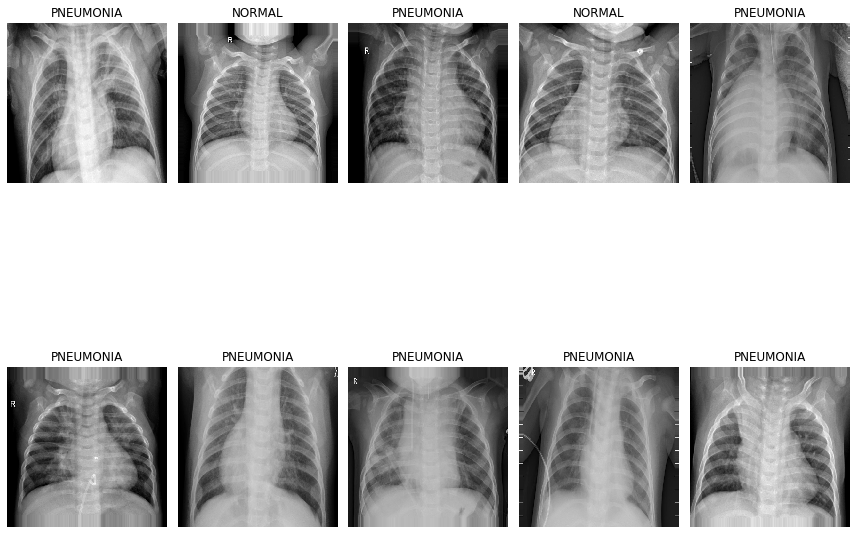

In [8]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

**Building the CNN**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [11]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)       

**Interpreting Model Summary**

In [13]:
# Hyperparameters of Conv2D
Conv2D(
    filters=32,
    kernel_size=3,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(500,500,1)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

**Visualize the CNN model**

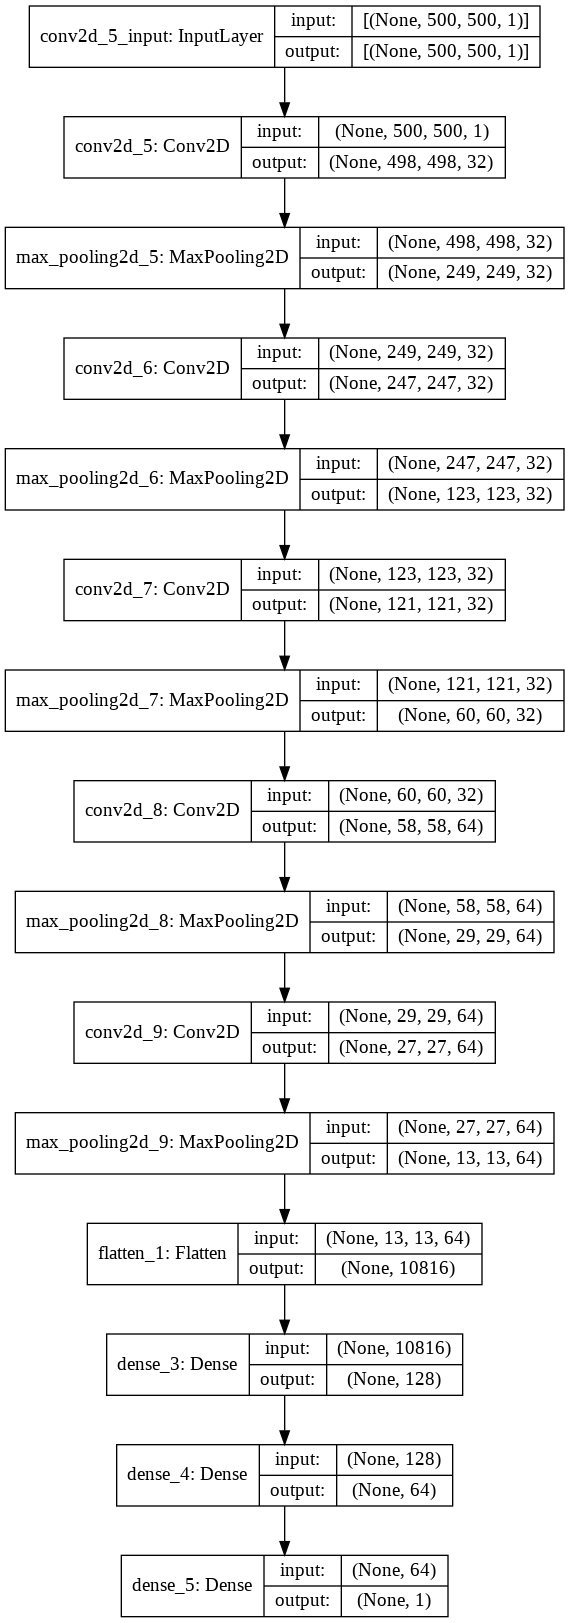

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [16]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

**Assigning Class Weights**

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


**Moving on to final step TRAINING**

In [20]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list) 

Epoch 1/5
262/262 [==============================] - 1088s 4s/step - loss: 0.1234 - accuracy: 0.9523 - val_loss: 0.1320 - val_accuracy: 0.9510
Epoch 2/5
262/262 [==============================] - 1085s 4s/step - loss: 0.1244 - accuracy: 0.9530 - val_loss: 0.1297 - val_accuracy: 0.9510
Epoch 3/5
262/262 [==============================] - 1086s 4s/step - loss: 0.1217 - accuracy: 0.9518 - val_loss: 0.1482 - val_accuracy: 0.9442
Epoch 4/5
262/262 [==============================] - 1087s 4s/step - loss: 0.1151 - accuracy: 0.9552 - val_loss: 0.1358 - val_accuracy: 0.9462

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 5/5
262/262 [==============================] - 1089s 4s/step - loss: 0.1133 - accuracy: 0.9530 - val_loss: 0.1308 - val_accuracy: 0.9519


**Evaluate**

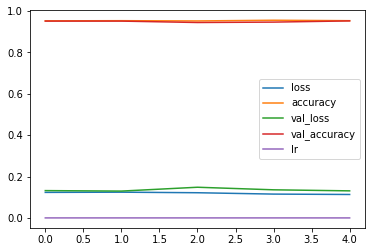

In [21]:
pd.DataFrame(cnn.history.history).plot()

In [22]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

65/65 [==============================] - 61s 937ms/step - loss: 0.1308 - accuracy: 0.9519
The testing accuracy is : 95.19230723381042 %


Let’s predict the test dataset and look at some of the performance measurement metrics in detail to evaluate our model.

In [23]:
preds = cnn.predict(test,verbose=1)

65/65 [==============================] - 62s 940ms/step


Since the activation function of the last layer is sigmoid, the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. Note(0 denotes a normal case and 1 denotes a case of pneumonia)

In [24]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

**Confusion Matrix**

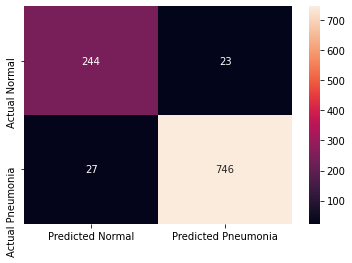

In [26]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

**Clasification Report**

In [27]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.90      0.91      0.91       267
   PNEUMONIA       0.97      0.97      0.97       773

    accuracy                           0.95      1040
   macro avg       0.94      0.94      0.94      1040
weighted avg       0.95      0.95      0.95      1040



**Let’s visualize some of the predicted images with percentage %**

(1040, 500, 500, 1)
(1040,)


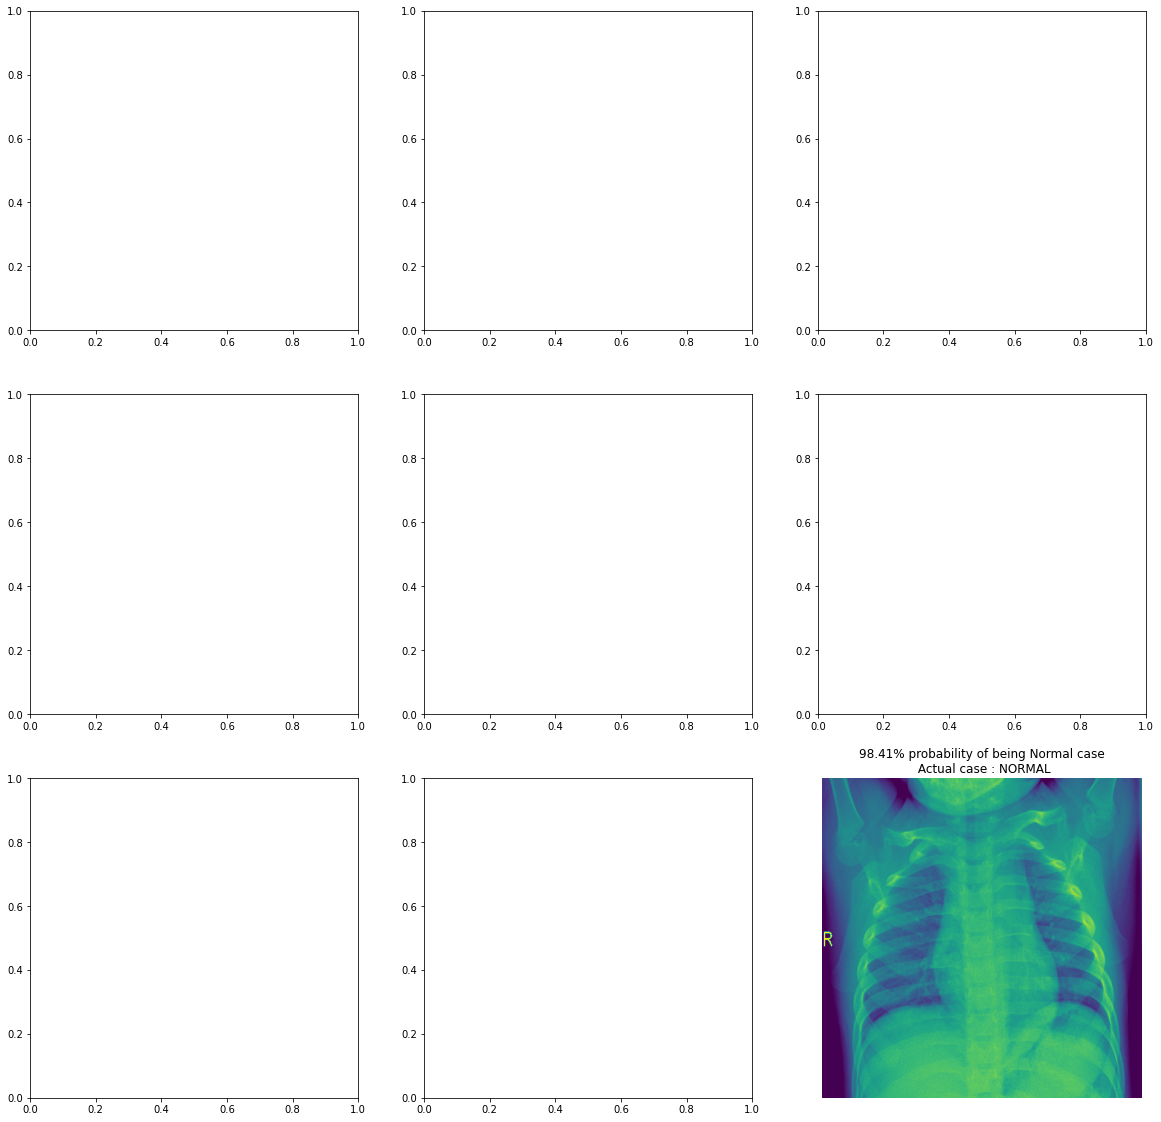

In [29]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()


**Predecting the X-ray images**

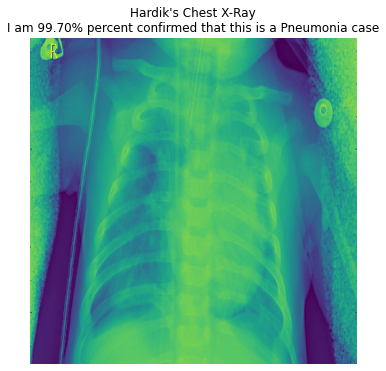

In [31]:
# Testing with my own Chest X-Ray
hardik_path = '/content/dataset/cnn/pneumonia_revamped/test/opacity/person100_bacteria_478.jpeg'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("Hardik's Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()